# Data Exploration Notebook for Approval Predict

## Objectives

Answerbusiness requirement 1:
The client is interested in determining which applicant variables are most strongly correlated with the loan approval outcome. They want a ranked list of variables to be provided based on their relevance and impact.

## Inputs

* outputs/datasets/collection/loan_approval.csv

## Outputs

* generate code that answers business requirement 1 and can be used to build the Streamlit App.

In [ ]:
import os
from pathlib import Path
import seaborn as sns
from feature_engine.encoding import OneHotEncoder
import matplotlib.pyplot as plt
from feature_engine.discretisation import ArbitraryDiscretiser
import numpy as np
import plotly.express as px
import pandas as pd

current_dir = os.getcwd()
current_dir

os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

current_dir = os.getcwd()
current_dir


You set a new current directory


'/workspaces/Approval_Predict'

Load Data

In [2]:
root = current_dir
file_path = Path(root) / "outputs" / "datasets" / "collection" / "loan_approval.csv"

if not file_path.exists():
    raise FileNotFoundError(f"Dataset not found at: {file_path}")

df = pd.read_csv(file_path).drop(['name'], axis=1)
df.head(3)


,city,income,credit_score,loan_amount,years_employed,points,loan_approved
0,East Jill,113810,389,39698,27,50.0,False
1,New Jamesside,44592,729,15446,28,55.0,False
2,Lake Roberto,33278,584,11189,13,45.0,False


Data Exploration

In [3]:
from ydata_profiling import ProfileReport
pandas_report = ProfileReport(df=df, minimal=True)
pandas_report.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [4]:
approve_counts = df['loan_approved'].value_counts()
approve_counts

loan_approved
False    1121
True      879
Name: count, dtype: int64

In [5]:
percentage_approved = df['loan_approved'].value_counts(normalize=True) * 100
percentage_approved

loan_approved
False    56.05
True     43.95
Name: proportion, dtype: float64

There is a moderate difference imbalance between loan approvals with false having a higher proportion meaning some models may be biased towards the rejection of loan approvals. The variables are split by 5 numbers, text and a boolean.

Drop feature 'city' as not useful for correlation.

In [6]:
df = df.drop(['city'], axis=1)

Convert the target (loan_approved) to an integer.

In [7]:
df['loan_approved'] = df['loan_approved'].astype(int)

Sample data with new feature (loan_to_income) to work out loan to income ratio.

In [8]:
df['loan_to_income'] = df['loan_amount'] / df['income']
df.head(10)

,income,credit_score,loan_amount,years_employed,points,loan_approved,loan_to_income
0,113810,389,39698,27,50.0,0,0.348809
1,44592,729,15446,28,55.0,0,0.346385
2,33278,584,11189,13,45.0,0,0.336228
3,127196,344,48823,29,50.0,0,0.383841
4,66048,496,47174,4,25.0,0,0.714238
5,62098,689,19217,29,65.0,1,0.309462
6,59256,373,40920,40,35.0,0,0.690563
7,48289,524,45866,20,25.0,0,0.949823
8,126530,367,14826,36,55.0,0,0.117174
9,43434,446,18359,8,20.0,0,0.422687


## Correlation study
This works out pairwise correlation coefficients between all numeric columns in the dataframe.

In [13]:
df.dtypes

income              int64
credit_score        int64
loan_amount         int64
years_employed      int64
points            float64
loan_approved       int64
loan_to_income    float64
dtype: object

In [15]:
corr_spearman = df.corr(method='spearman')['loan_approved'].sort_values(key=abs, ascending=False)[1:].head(10)
corr_spearman

points            0.862704
credit_score      0.713124
loan_to_income   -0.262813
income            0.237363
loan_amount      -0.158243
years_employed    0.104049
Name: loan_approved, dtype: float64

In [16]:
corr_pearson = df.corr(method='pearson')['loan_approved'].sort_values(key=abs, ascending=False)[1:].head(10)
corr_pearson

points            0.821415
credit_score      0.715788
loan_to_income   -0.249378
income            0.238066
loan_amount      -0.157859
years_employed    0.104408
Name: loan_approved, dtype: float64

Spearman correlation measures monotonic relationships, in which variables move in the same direction but not necessarily linear.
Pearson method measures linear relationships, in which 1 is a positive correlation and -1 is a negative correlation.
In the spearman correlation the variable points and credit score have a strong positive correlation suggesting as points increase so does loan approval.
income and loan_amount had a weak correlation and years_employed had a very weak correlation. This would suggest a higher income and lower loan amount would increase loan approval with more year employed slightly improving chances of approval.
The city variable has an extremely weak correlation and has little effect on loan approval. 

Pearson correlation showed a similiar pattern where points and credit score had a strong positive correlation and income had a very weak correlation.

In [17]:
vars_to_study = ['points', 'credit_score', 'income', 'loan_amount', 'years_employed']
vars_to_study

['points', 'credit_score', 'income', 'loan_amount', 'years_employed']

EDA on selected variables

In [18]:
df_eda = df.filter(vars_to_study + ['loan_approved'])
df_eda.head(3)

,points,credit_score,income,loan_amount,years_employed,loan_approved
0,50.0,389,113810,39698,27,0
1,55.0,729,44592,15446,28,0
2,45.0,584,33278,11189,13,0


Variables Distribution by loan approved

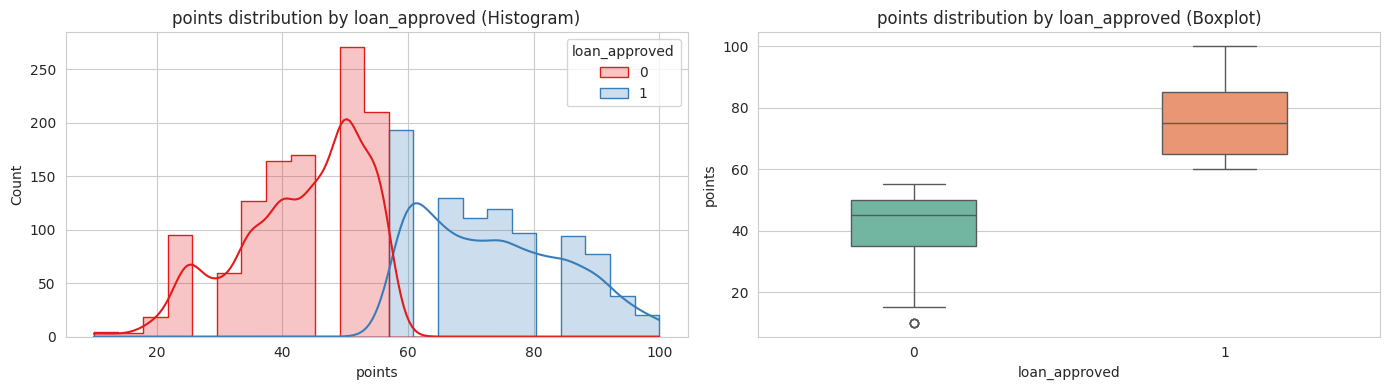

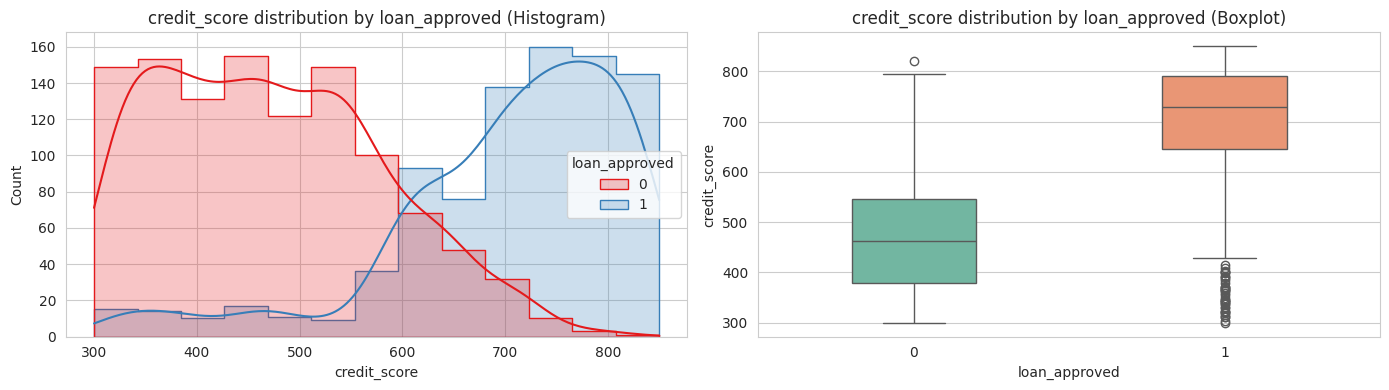

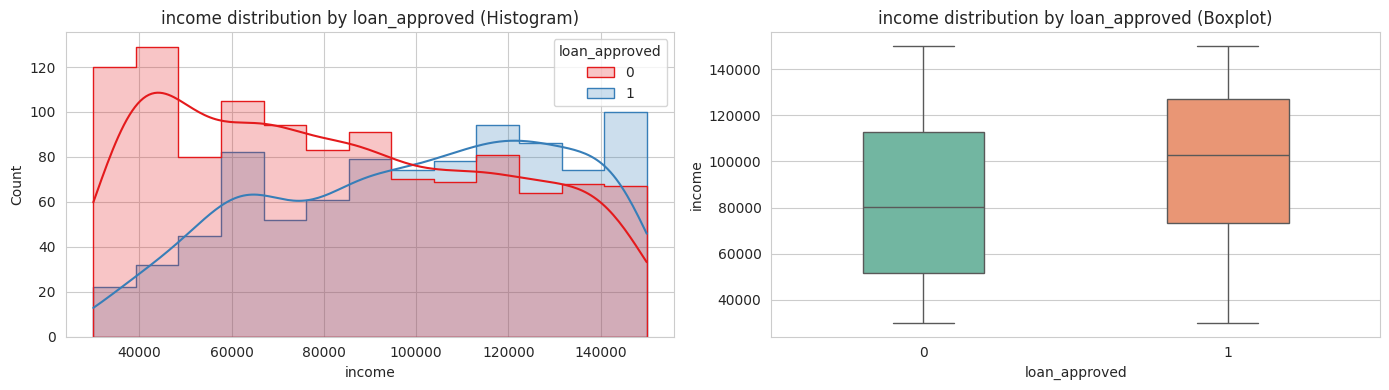

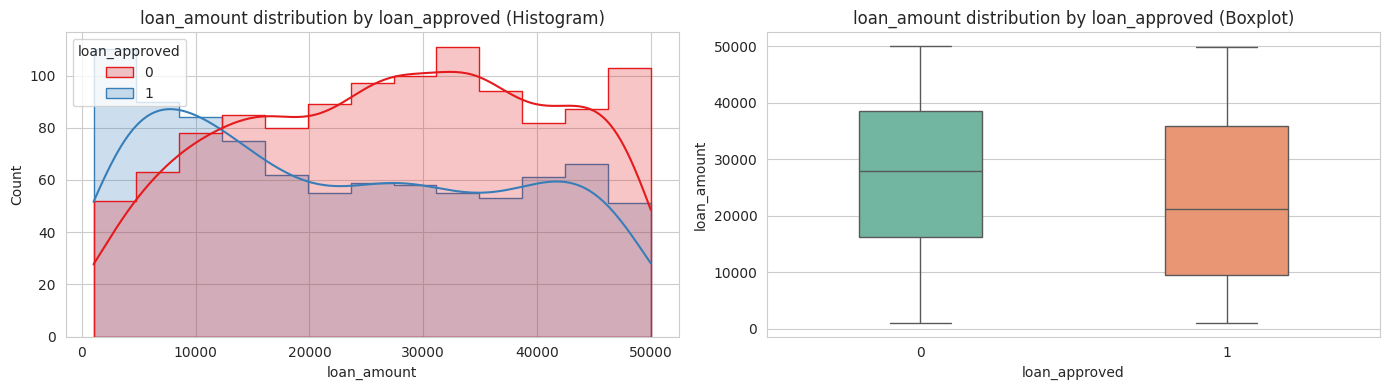

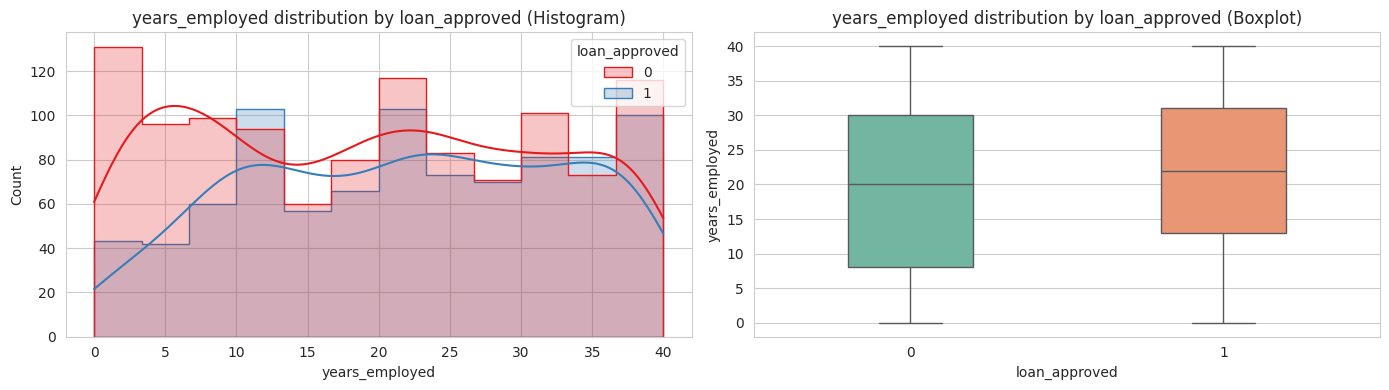

In [29]:
%matplotlib inline
sns.set_style('whitegrid')


def plot_numerical(df, vars_to_study, target_var):
    for col in vars_to_study:
        fig, axes = plt.subplots(1, 2, figsize=(14, 4))
        
        # Histogram
        sns.histplot(
            data=df, x=col, hue=target_var, kde=True, element="step",
            palette='Set1', ax=axes[0]
        )
        axes[0].set_title(f"{col} distribution by {target_var} (Histogram)")
        
        # Boxplot
        sns.boxplot(
            data=df, x=target_var, y=col, palette='Set2', width=0.4, ax=axes[1]
        )
        axes[1].set_title(f"{col} distribution by {target_var} (Boxplot)")
        
        plt.tight_layout()
        plt.show()

target_var = 'loan_approved'

plot_numerical(df, vars_to_study, target_var)


Points distribution by loan approved summary

This shows applicants with approved loans have significantly higher points compared to those with rejected loans.

The median points for approved loans is around 75, while for not approved it’s around 45. Therefore, higher points are strongly associated with higher chances of loan approval.

The histogram suggests applicants with higher points are much more likely to get loan approval. Those with lower points of <60 are mostly rejected, while applicants with points above ~70 are primarily approved.

Credit score distribution by loan approved

This shows approved applicants have much higher credit scores.

The median credit score for approved loans is around 700–750. For non-approved loans, the median is around 450–500. Therefore, Credit score appears to be a key predictor.

The histrogram suggests credit scores below 600 are more likely to be rejected, while above 650 are mostly approved.

Income distribution by loan approved

This shows approved applicants generally have higher incomes.

The median income for approved loans is around 100,000, compared to about 80,000 for non-approved.

Income influences approval, but the difference is less pronounced than for credit score or points.

The histrogram suggests higher income levels correspond to higher loan approval rates. Applicants earning below ~70k have more rejections, while those above ~90k tend to get approved.

Loan amount distribution by loan approved

This shows loan amounts are quite similar between approved and non-approved groups.

The median loan amount for approved loans is slightly lower than for rejected loans. Therefore, applicants asking for larger loans may be more likely to be rejected.

The histogram suggests applicants requesting larger loans are less likely to be approved, while those asking for smaller to moderate loan amounts have a higher chance of approval.

Years employed distribution by loan approved

This shows years employed appears to have a positive relationship with loan approval. However, the median difference is small, and there’s overlap between the groups.

This suggests that while employment stability helps, it’s not the strongest predictor.

The histogram suggests applicants with longer employment histories are slightly more likely to be approved, but there are still many rejections across all experience levels.

In [21]:
sns.heatmap(df_eda.corr(numeric_only=True), annot=True, cmap='coolwarm')


<Axes: title={'center': 'years_employed distribution by loan_approved (Boxplot)'}>

In [ ]:
sns.set_style('whitegrid')

numeric_vars = df_eda.select_dtypes(include='int').columns.drop('loan_approved')

for col in numeric_vars:
    plt.figure(figsize=(6,4))
    sns.barplot(data=df_eda, x='loan_approved', y=col, estimator='mean', ci=None, palette='viridis')
    plt.title(f'Average {col} by Loan Approval', fontsize=14)
    plt.xlabel('Loan Approved (0 = No, 1 = Yes)')
    plt.ylabel(f'Average {col}')
    plt.tight_layout()
    plt.show()

Discretize credit_score and points and Parallel plot

In [ ]:
credit_map = [-np.inf, 580, 670, 740, 800, np.inf]
points_map = [-np.inf, 40, 60, 80, np.inf]

disc = ArbitraryDiscretiser(binning_dict={
    'credit_score': credit_map,
    'points': points_map
})

df_disc = disc.fit_transform(df_eda.copy())

In [ ]:
def make_label_map(binner_dict, variable):
    bins = binner_dict[variable]
    n_classes = len(bins) - 1
    classes_ranges = bins[1:-1]
    labels_map = {}
    for n in range(n_classes):
        if n == 0:
            labels_map[n] = f"<{classes_ranges[0]}"
        elif n == n_classes - 1:
            labels_map[n] = f"+{classes_ranges[-1]}"
        else:
            labels_map[n] = f"{classes_ranges[n-1]} to {classes_ranges[n]}"
    return labels_map

for var in ['credit_score', 'points']:
    df_disc[var] = df_disc[var].replace(make_label_map(disc.binner_dict_, var))


In [ ]:
fig = px.parallel_categories(
    df_disc[['credit_score', 'points', 'income', 'loan_approved']],
    color="loan_approved",
    color_continuous_scale=px.colors.sequential.Viridis
)
fig.show()


The plot suggests:

Credit score and points are both positively correlated with loan approval.

Applicants with low credit score and low points have the highest rejection rates.

Applicants with high credit score and high points almost always get approved.

## Conclusions and Next Steps

This

Next steps:
